In [614]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit.library import StatePreparation
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit.circuit.library import QFT

def add_constant(n_qubits: int, c: int) -> QuantumCircuit:
    """Returns a circuit that maps |x⟩ → |(x + c) mod 2^n⟩."""
    qc = QuantumCircuit(n_qubits, name=f"+{c}")
    qc.append(QFT(n_qubits, do_swaps=False), range(n_qubits))
    for k in range(n_qubits):
        angle = 2 * np.pi * c / (2 ** (k + 1))
        qc.p(angle, k)          # P(θ)|0⟩=|0⟩, P(θ)|1⟩=e^{iθ}|1⟩

    qc.append(QFT(n_qubits, do_swaps=False, inverse=True), range(n_qubits))

    return qc

def prepare_sto_state(n_qubits: int, a: float) -> QuantumCircuit:
    """Returns a circuit that prepares the state |ψ⟩ = N · Σ e^(-a·|i|) |i⟩."""
    qc = QuantumCircuit(n_qubits)
    last_qubit = n_qubits - 1

    qc.h(last_qubit)
    #qc.x(last_qubit)

    b = a
    for i in range(n_qubits-1):
        theta = 2 * np.arctan(np.exp(b))
        qc.cry(theta, last_qubit, i)
        b = b * 2
    qc.x(last_qubit)

    b = a
    for i in range(n_qubits-1):
        theta = 2 * np.arctan(np.exp(-b))
        qc.cry(theta, last_qubit, i)
        b = b * 2

    qc.x(last_qubit)

    return qc


def sto(n_qubits: int, a: float, center: int) -> QuantumCircuit:
    """Returns a circuit that prepares the state |ψ⟩ = N · Σ e^(-a·|i-center|) |i-center⟩."""
    qc = QuantumCircuit(n_qubits)
    qc.compose(prepare_sto_state(n_qubits, a), inplace=True)
    qc.compose(add_constant(n_qubits, center), inplace=True)

    return qc

def sto_dagger(n_qubits: int, a: float, center: int) -> QuantumCircuit:
    qc = QuantumCircuit(n_qubits)
    qc.compose(add_constant_dagger(n_qubits, center), inplace=True)
    qc.compose(prepare_sto_state_dagger(n_qubits, a), inplace=True)
    
    return qc

def add_constant_dagger(n_qubits: int, c: int) -> QuantumCircuit:
    qc = QuantumCircuit(n_qubits, name=f"+{c}")
    qc.append(QFT(n_qubits, do_swaps=False), range(n_qubits))
    for k in range(n_qubits):
        angle = -2 * np.pi * c / (2 ** (k + 1))
        qc.p(angle, k)          # P(θ)|0⟩=|0⟩, P(θ)|1⟩=e^{iθ}|1⟩

    qc.append(QFT(n_qubits, do_swaps=False, inverse=True), range(n_qubits))
    
    return qc

def prepare_sto_state_dagger(n_qubits: int, a: float) -> QuantumCircuit:
    """Returns a circuit that prepares the state |ψ⟩ = N · Σ e^(-a·|i|) |i⟩."""
    qc = QuantumCircuit(n_qubits)
    last_qubit = n_qubits - 1

    qc.x(last_qubit)

    b = a
    for i in range(n_qubits-1):
        theta = 2 * np.arctan(np.exp(-b))
        qc.cry(-theta, last_qubit, i)
        b = b * 2
        
    qc.x(last_qubit)

    b = a
    for i in range(n_qubits-1):
        theta = 2 * np.arctan(np.exp(b))
        qc.cry(-theta, last_qubit, i)
        b = b * 2

    qc.h(last_qubit)
    return qc

In [637]:
# Decaying exponential state: |ψ⟩ = N · Σ e^(-a·i) |i⟩  for i = 0 … 2^4-1
a = 1  # decay constant
n_qubits = 8
max_range = 16

scale = max_range / (2 ** n_qubits)
scaled_a = a * scale

center1 = 2 ** (n_qubits - 1)
center2 = 2 ** (n_qubits - 1) + 22

qc = sto(n_qubits, scaled_a, center2)
# qc.compose(sto_dagger(n_qubits, scaled_a, center2), inplace=True)

qc.draw('mpl', style='iqp')

print(center1)
print(center2)

128
150


C:\Users\sorin\AppData\Local\Temp\ipykernel_34708\2601810974.py:13: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=False), range(n_qubits))
C:\Users\sorin\AppData\Local\Temp\ipykernel_34708\2601810974.py:18: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=False, inverse=True), range(n_qubits))


In [638]:
# Simulate the statevector using Qiskit's local statevector simulator
sv = Statevector(qc)

print("Statevector amplitudes (|basis⟩ : amplitude):")
for i, amp in enumerate(sv.data):
    basis = format(i, f'0{n_qubits}b')
    if abs(amp) > 1e-6:
        print(f"  |{basis}⟩ : {amp:.4f}  (prob = {abs(amp)**2:.4f})")


Statevector amplitudes (|basis⟩ : amplitude):
  |00000000⟩ : 0.0003+0.0000j  (prob = 0.0000)
  |00000001⟩ : 0.0003+0.0000j  (prob = 0.0000)
  |00000010⟩ : 0.0003+0.0000j  (prob = 0.0000)
  |00000011⟩ : 0.0003+0.0000j  (prob = 0.0000)
  |00000100⟩ : 0.0003+0.0000j  (prob = 0.0000)
  |00000101⟩ : 0.0002+0.0000j  (prob = 0.0000)
  |00000110⟩ : 0.0002+0.0000j  (prob = 0.0000)
  |00000111⟩ : 0.0002+0.0000j  (prob = 0.0000)
  |00001000⟩ : 0.0002+0.0000j  (prob = 0.0000)
  |00001001⟩ : 0.0002+0.0000j  (prob = 0.0000)
  |00001010⟩ : 0.0002+0.0000j  (prob = 0.0000)
  |00001011⟩ : 0.0002+0.0000j  (prob = 0.0000)
  |00001100⟩ : 0.0002+0.0000j  (prob = 0.0000)
  |00001101⟩ : 0.0001+0.0000j  (prob = 0.0000)
  |00001110⟩ : 0.0001+0.0000j  (prob = 0.0000)
  |00001111⟩ : 0.0001+0.0000j  (prob = 0.0000)
  |00010000⟩ : 0.0001+0.0000j  (prob = 0.0000)
  |00010001⟩ : 0.0001+0.0000j  (prob = 0.0000)
  |00010010⟩ : 0.0001+0.0000j  (prob = 0.0000)
  |00010011⟩ : 0.0001+0.0000j  (prob = 0.0000)
  |00010100⟩ :

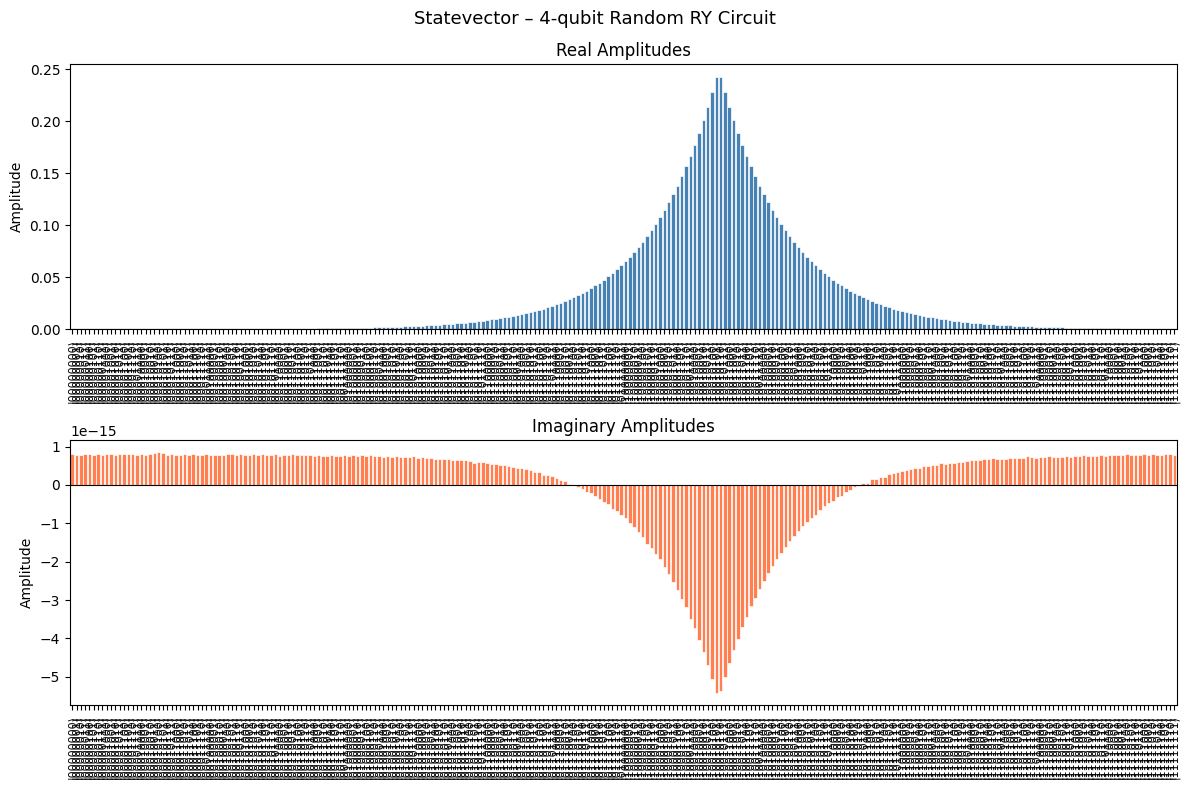

In [639]:

# Visualize statevector: two vertical bar charts stacked (real on top, imaginary below)
n_states = 2 ** n_qubits
basis_labels = [format(i, f'0{n_qubits}b') for i in range(n_states)]
real_parts = sv.data.real
imag_parts = sv.data.imag

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
fig.suptitle("Statevector – 4-qubit Random RY Circuit", fontsize=13)

x = np.arange(n_states)

ax1.bar(x, real_parts, color='steelblue', edgecolor='white', linewidth=0.5)
ax1.axhline(0, color='black', linewidth=0.8)
ax1.set_title("Real Amplitudes")
ax1.set_xticks(x)
ax1.set_xticklabels([f'|{b}⟩' for b in basis_labels], rotation=90, fontsize=8)
ax1.set_ylabel("Amplitude")
ax1.set_xlim(-0.5, n_states - 0.5)

ax2.bar(x, imag_parts, color='coral', edgecolor='white', linewidth=0.5)
ax2.axhline(0, color='black', linewidth=0.8)
ax2.set_title("Imaginary Amplitudes")
ax2.set_xticks(x)
ax2.set_xticklabels([f'|{b}⟩' for b in basis_labels], rotation=90, fontsize=8)
ax2.set_ylabel("Amplitude")
ax2.set_xlim(-0.5, n_states - 0.5)

plt.tight_layout()
plt.show()


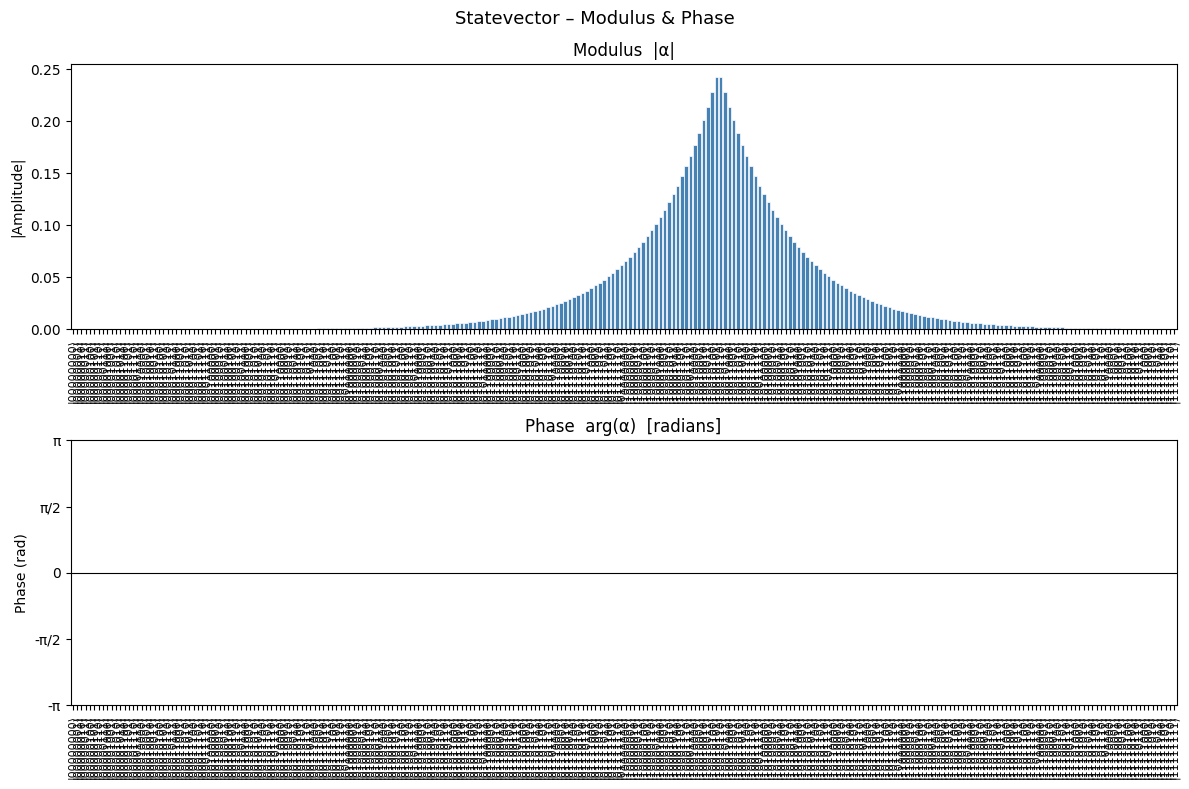

In [640]:
# Visualize statevector: modulus and phase stacked vertically
modulus = np.abs(sv.data)
phase = np.angle(sv.data)   # radians in (-π, π]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
fig.suptitle("Statevector – Modulus & Phase", fontsize=13)

x = np.arange(n_states)
tick_labels = [f'|{b}⟩' for b in basis_labels]

ax1.bar(x, modulus, color='steelblue', edgecolor='white', linewidth=0.5)
ax1.set_title("Modulus  |α|")
ax1.set_xticks(x)
ax1.set_xticklabels(tick_labels, rotation=90, fontsize=8)
ax1.set_ylabel("|Amplitude|")
ax1.set_xlim(-0.5, n_states - 0.5)
ax1.set_ylim(bottom=0)

ax2.bar(x, phase, color='darkorange', edgecolor='white', linewidth=0.5)
ax2.axhline(0, color='black', linewidth=0.8)
ax2.set_title("Phase  arg(α)  [radians]")
ax2.set_xticks(x)
ax2.set_xticklabels(tick_labels, rotation=90, fontsize=8)
ax2.set_ylabel("Phase (rad)")
ax2.set_xlim(-0.5, n_states - 0.5)
ax2.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax2.set_yticklabels(['-π', '-π/2', '0', 'π/2', 'π'])

plt.tight_layout()
plt.show()


Measurement results (1024 shots):
  |01010001⟩ :    1  
  |01101100⟩ :    1  
  |01101110⟩ :    1  
  |01101111⟩ :    2  
  |01110010⟩ :    2  
  |01110110⟩ :    2  
  |01110111⟩ :    1  
  |01111001⟩ :    2  
  |01111010⟩ :    1  
  |01111011⟩ :    5  
  |01111100⟩ :    3  
  |01111101⟩ :    3  
  |01111110⟩ :    4  
  |01111111⟩ :    3  
  |10000000⟩ :    7  
  |10000001⟩ :    1  
  |10000010⟩ :    3  
  |10000011⟩ :    2  
  |10000100⟩ :   12  
  |10000101⟩ :    5  
  |10000110⟩ :    7  
  |10000111⟩ :    6  
  |10001000⟩ :   11  
  |10001001⟩ :    8  
  |10001010⟩ :   16  
  |10001011⟩ :   15  
  |10001100⟩ :   19  
  |10001101⟩ :   24  
  |10001110⟩ :   30  █
  |10001111⟩ :   34  █
  |10010000⟩ :   26  █
  |10010001⟩ :   37  █
  |10010010⟩ :   40  █
  |10010011⟩ :   47  █
  |10010100⟩ :   54  ██
  |10010101⟩ :   66  ██
  |10010110⟩ :   59  ██
  |10010111⟩ :   56  ██
  |10011000⟩ :   48  █
  |10011001⟩ :   41  █
  |10011010⟩ :   30  █
  |10011011⟩ :   35  █
  |10011100⟩ :   20  
  

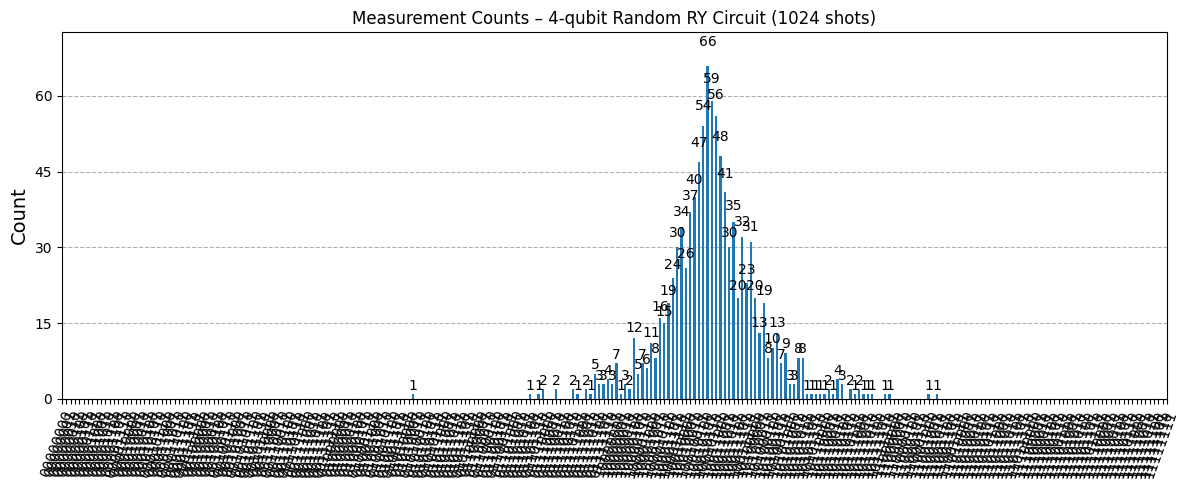

In [641]:
# Sample the statevector to get measurement counts (local simulator)
shots = 1024
counts = sv.sample_counts(shots)

print(f"Measurement results ({shots} shots):")
for state in sorted(counts.keys()):
    bar = '█' * int(counts[state] / shots * 40)
    print(f"  |{state}⟩ : {counts[state]:4d}  {bar}")

# Include all 2^n basis states (zeros for unobserved states)
all_basis = [format(i, f'0{n_qubits}b') for i in range(2 ** n_qubits)]
counts_full = {b: counts.get(b, 0) for b in all_basis}

# Plot histogram of sample counts
fig = plot_histogram(
    counts_full,
    title=f"Measurement Counts – 4-qubit Random RY Circuit ({shots} shots)",
    figsize=(12, 5),
    bar_labels=True,
)
fig.tight_layout()
display(fig)


In [650]:
# Decaying exponential state: |ψ⟩ = N · Σ e^(-a·i) |i⟩  for i = 0 … 2^4-1
a = 1  # decay constant
n_qubits = 8
max_range = 16

scale = max_range / (2 ** n_qubits)
scaled_a = a * scale

center1 = 2 ** (n_qubits - 1)
center2 = 2 ** (n_qubits - 1) + 22

qc = sto(n_qubits, scaled_a, center1)
qc.compose(sto_dagger(n_qubits, scaled_a, center2), inplace=True)

sv_overlap = Statevector(qc)
S_exact = sv_overlap.data[0].real      # amplitude of |0…0⟩  (purely real)
P_exact = abs(sv_overlap.data[0])**2  # = S²

print(f"Exact (statevector) amplitude  ⟨0|circuit|0⟩ = {S_exact:.6f}")
print(f"Exact (statevector) |S|²       P(|0…0⟩)      = {P_exact:.6f}")
print(f"Exact S = √P                                  = {np.sqrt(P_exact):.6f}")
print()

shots = 9000
counts_ov = sv_overlap.sample_counts(shots)
p_zero_sampled = counts_ov.get('0' * n_qubits, 0) / shots
S_sampled = np.sqrt(p_zero_sampled)

print(f"Sampler ({shots} shots):")
print(f"  Counts for |{'0'*n_qubits}⟩  = {counts_ov.get('0'*n_qubits, 0)}")
print(f"  P(|0…0⟩)  = {p_zero_sampled:.6f}")
print(f"  S = √P    = {S_sampled:.6f}")
print()
print(f"Shot noise:           {abs(S_sampled - S_exact):.4f}  ({abs(S_sampled - S_exact)/S_exact*100:.2f} %)")

Exact (statevector) amplitude  ⟨0|circuit|0⟩ = 0.600721
Exact (statevector) |S|²       P(|0…0⟩)      = 0.360865
Exact S = √P                                  = 0.600721

Sampler (9000 shots):
  Counts for |00000000⟩  = 3231
  P(|0…0⟩)  = 0.359000
  S = √P    = 0.599166

Shot noise:           0.0016  (0.26 %)


C:\Users\sorin\AppData\Local\Temp\ipykernel_34708\2601810974.py:13: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=False), range(n_qubits))
C:\Users\sorin\AppData\Local\Temp\ipykernel_34708\2601810974.py:18: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=False, inverse=True), range(n_qubits))
C:\Users\sorin\AppData\Local\Temp\ipykernel_34708\2601810974.py:65: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be r

In [642]:
# ── Normalization analysis: discrete vs continuous ────────────────────────────
dx = scale                            # grid spacing in atomic units
Z_discrete = np.sum(np.exp(-2 * scaled_a * np.abs(np.arange(2**n_qubits) - center1)))
N_discrete  = 1.0 / np.sqrt(Z_discrete)

# What does the continuous formula predict for the peak amplitude?
# Continuous: N_1D = sqrt(a_phys) = 1, but the discrete amplitude ~ sqrt(a_phys * dx)
N_predicted = np.sqrt(a * dx)         # = sqrt(scale) for a=1

# Peak quantum amplitude from statevector
peak_amp = float(np.max(np.abs(sv.data)))

# Recover the physical wavefunction value at the peak by dividing by sqrt(dx)
psi_peak_recovered = peak_amp / np.sqrt(dx)

print(f"n_qubits             = {n_qubits}")
print(f"Grid spacing  dx     = {dx}  a.u.")
print(f"scaled_a             = {scaled_a}")
print(f"Z (discrete sum)     = {Z_discrete:.6f}")
print(f"1 / (a · dx)         = {1/(a*dx):.6f}   (continuous approx of Z)")
print()
print(f"N_discrete    = 1/√Z         = {N_discrete:.6f}")
print(f"N_predicted   = √(a·dx)      = {N_predicted:.6f}   (continuous limit)")
print(f"Peak |α|  from statevector   = {peak_amp:.6f}")
print()
print(f"Physical ψ(c) = peak / √dx   = {psi_peak_recovered:.6f}")
print(f"Continuous ψ(0) = √a · e^0   = {np.sqrt(a):.6f}   (should match)")


n_qubits             = 8
Grid spacing  dx     = 0.0625  a.u.
scaled_a             = 0.0625
Z (discrete sum)     = 16.020826
1 / (a · dx)         = 16.000000   (continuous approx of Z)

N_discrete    = 1/√Z         = 0.249837
N_predicted   = √(a·dx)      = 0.250000   (continuous limit)
Peak |α|  from statevector   = 0.242387

Physical ψ(c) = peak / √dx   = 0.969549
Continuous ψ(0) = √a · e^0   = 1.000000   (should match)


In [643]:
# ── Inspect amplitudes around the centre to test the "peak between grid points" hypothesis ──
amps = np.abs(sv.data)
window = 5

print(f"{'index':>8}  {'|α_i|':>12}  {'ideal e^(-a|i-c|)*N_d':>24}  {'ratio':>8}")
print("-" * 60)
for k in range(center1 - window, center1 + window + 1):
    ideal = N_discrete * np.exp(-scaled_a * abs(k - center1))
    ratio = amps[k] / ideal if ideal > 0 else float('nan')
    marker = " ← centre" if k == center1 else (
             " ← left neighbour" if k == center1 - 1 else (
             " ← right neighbour" if k == center1 + 1 else ""))
    print(f"{k:>8}  {amps[k]:>12.8f}  {ideal:>24.8f}  {ratio:>8.6f}{marker}")

print()
print(f"Amplitude at centre   |α_{center1}|  = {amps[center1]:.8f}")
print(f"Amplitude at c-1      |α_{center1-1}| = {amps[center1-1]:.8f}")
print(f"Amplitude at c+1      |α_{center1+1}| = {amps[center1+1]:.8f}")
print()
# Are the two neighbours equal? (symmetry check)
print(f"Left/right symmetry: |α_{{c-1}}| / |α_{{c+1}}| = {amps[center1-1]/amps[center1+1]:.8f}  (1.0 = perfectly symmetric)")
# Is the centre the unique maximum?
print(f"Centre is maximum: {amps[center1] >= amps[center1-1] and amps[center1] >= amps[center1+1]}")
print(f"Centre vs N_discrete: {amps[center1]:.8f} vs {N_discrete:.8f}  (ratio {amps[center1]/N_discrete:.6f})")


   index         |α_i|     ideal e^(-a|i-c|)*N_d     ratio
------------------------------------------------------------
     123    0.04772887                0.18278499  0.261120
     124    0.05080712                0.19457361  0.261120
     125    0.05408390                0.20712252  0.261120
     126    0.05757201                0.22048078  0.261120
     127    0.06128508                0.23470057  0.261120 ← left neighbour
     128    0.06523763                0.24983745  0.261120 ← centre
     129    0.06944510                0.23470057  0.295888 ← right neighbour
     130    0.07392392                0.22048078  0.335285
     131    0.07869160                0.20712252  0.379928
     132    0.08376678                0.19457361  0.430515
     133    0.08916927                0.18278499  0.487837

Amplitude at centre   |α_128|  = 0.06523763
Amplitude at c-1      |α_127| = 0.06128508
Amplitude at c+1      |α_129| = 0.06944510

Left/right symmetry: |α_{c-1}| / |α_{c+1}| = 0.88249690

In [644]:
# ── Overlap circuit:  O₂† · O₁ · |0⟩ ────────────────────────────────────────
# S = ⟨ψ₁|ψ₂⟩ = ⟨0|O₁†O₂|0⟩  ⟹  circuit = O₁† O₂ (or equivalently O₂† O₁)
# P(|0…0⟩) = |S|²   →   S = √P  (real, positive wavefunctions)

# center1 effective max is at index 127.5  → physical position 127.5 * dx = 7.96875
# center2 = 150: effective max at 149.5    → physical position 149.5 * dx = 9.34375
# separation d = (149.5 - 127.5) * dx = 22 * (1/16) = 1.375 a.u.  ≈ 1.4 a.u.

center2_overlap = 150
d_grid  = (149.5 - 127.5) * scale          # effective physical separation
S_cont  = (1 + a * d_grid) * np.exp(-a * d_grid)   # continuous benchmark

# Build the overlap circuit
qc_overlap = QuantumCircuit(n_qubits)
qc_overlap.compose(sto(n_qubits, scaled_a, center1),               inplace=True)  # O₁|0⟩
qc_overlap.compose(sto_dagger(n_qubits, scaled_a, center2_overlap), inplace=True)  # O₂†

# ── Exact overlap via statevector (ground truth) ──────────────────────────────
sv_overlap = Statevector(qc_overlap)
S_exact = sv_overlap.data[0].real      # amplitude of |0…0⟩  (purely real)
P_exact = abs(sv_overlap.data[0])**2  # = S²

print(f"Effective separation    d  = {d_grid:.4f} a.u.  (closest to 1.4 a.u.)")
print(f"Continuous benchmark    S  = {S_cont:.6f}")
print()
print(f"Exact (statevector) amplitude  ⟨0|circuit|0⟩ = {S_exact:.6f}")
print(f"Exact (statevector) |S|²       P(|0…0⟩)      = {P_exact:.6f}")
print(f"Exact S = √P                                  = {np.sqrt(P_exact):.6f}")
print()

# ── Sampler estimation ────────────────────────────────────────────────────────
# With a real quantum device / Qiskit Sampler you measure all qubits and count |0…0⟩.
# Here we simulate that by drawing samples from the statevector.
shots = 8192
counts_ov = sv_overlap.sample_counts(shots)
p_zero_sampled = counts_ov.get('0' * n_qubits, 0) / shots
S_sampled = np.sqrt(p_zero_sampled)

print(f"Sampler ({shots} shots):")
print(f"  Counts for |{'0'*n_qubits}⟩  = {counts_ov.get('0'*n_qubits, 0)}")
print(f"  P(|0…0⟩)  = {p_zero_sampled:.6f}")
print(f"  S = √P    = {S_sampled:.6f}")
print()
print(f"Error vs continuous:  {abs(S_sampled - S_cont):.4f}  ({abs(S_sampled - S_cont)/S_cont*100:.2f} %)")
print(f"Discretisation error: {abs(S_exact  - S_cont):.4f}  ({abs(S_exact  - S_cont)/S_cont*100:.2f} %)")
print(f"Shot noise:           {abs(S_sampled - S_exact):.4f}  ({abs(S_sampled - S_exact)/S_exact*100:.2f} %)")


Effective separation    d  = 1.3750 a.u.  (closest to 1.4 a.u.)
Continuous benchmark    S  = 0.600494

Exact (statevector) amplitude  ⟨0|circuit|0⟩ = 0.600721
Exact (statevector) |S|²       P(|0…0⟩)      = 0.360865
Exact S = √P                                  = 0.600721

Sampler (8192 shots):
  Counts for |00000000⟩  = 3018
  P(|0…0⟩)  = 0.368408
  S = √P    = 0.606966

Error vs continuous:  0.0065  (1.08 %)
Discretisation error: 0.0002  (0.04 %)
Shot noise:           0.0062  (1.04 %)


C:\Users\sorin\AppData\Local\Temp\ipykernel_34708\2601810974.py:13: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=False), range(n_qubits))
C:\Users\sorin\AppData\Local\Temp\ipykernel_34708\2601810974.py:18: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=False, inverse=True), range(n_qubits))
C:\Users\sorin\AppData\Local\Temp\ipykernel_34708\2601810974.py:65: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be r